In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, 
                                     Dense, Dropout, MaxPooling1D, Bidirectional, 
                                     LSTM, Concatenate, Average)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
# Load text data
text_data_path = 'F:/MS Thesis/RND/BanglaText.csv'
df_text = pd.read_csv(text_data_path)

# Encode emotion labels
label_encoder = LabelEncoder()
df_text['Encoded_Emotion'] = label_encoder.fit_transform(df_text['Emotion'])
y_text = df_text['Encoded_Emotion']

# Tokenization and Padding
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_text['Cleaned_Text'])

X_text = tokenizer.texts_to_sequences(df_text['Cleaned_Text'])
X_text = pad_sequences(X_text, maxlen=MAX_SEQ_LEN)

# Train-Test Split for Text
X_train_text, X_temp_text, y_train_text, y_temp_text = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)
X_val_text, X_test_text, y_val_text, y_test_text = train_test_split(
    X_temp_text, y_temp_text, test_size=0.5, random_state=42, stratify=y_temp_text
)

# Convert labels to one-hot encoding
y_train_text = to_categorical(y_train_text, num_classes=6)
y_val_text = to_categorical(y_val_text, num_classes=6)
y_test_text = to_categorical(y_test_text, num_classes=6)


In [8]:
# Load voice features and labels
X_voice = np.load('F:/MS Thesis/Research/Data/features.npy')
y_voice = np.load('F:/MS Thesis/Research/Data/labels.npy')

# Reshape X_voice if needed
if len(X_voice.shape) == 2:
    X_voice = X_voice.reshape((X_voice.shape[0], X_voice.shape[1], 1))

# Convert string labels to integers
label_map = {label: idx for idx, label in enumerate(np.unique(y_voice))}
y_voice = np.array([label_map[label] for label in y_voice])

# Split the data into train, validation, and test sets
X_train_voice, X_temp_voice, y_train_voice, y_temp_voice = train_test_split(
    X_voice, y_voice, test_size=0.2, random_state=42, stratify=y_voice
)
X_val_voice, X_test_voice, y_val_voice, y_test_voice = train_test_split(
    X_temp_voice, y_temp_voice, test_size=0.5, random_state=42, stratify=y_temp_voice
)

# Convert labels to one-hot encoding
y_train_voice = to_categorical(y_train_voice, num_classes=6)
y_val_voice = to_categorical(y_val_voice, num_classes=6)
y_test_voice = to_categorical(y_test_voice, num_classes=6)


In [9]:
text_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu')
])


E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
voice_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_voice.shape[1], X_train_voice.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu')
])


E:\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
def early_fusion_model():
    text_input = Input(shape=(MAX_SEQ_LEN,))
    voice_input = Input(shape=(X_train_voice.shape[1], X_train_voice.shape[2]))

    text_features = text_model(text_input)
    voice_features = voice_model(voice_input)

    fused_features = Concatenate()([text_features, voice_features])
    dense_1 = Dense(64, activation='relu')(fused_features)
    output = Dense(6, activation='softmax')(dense_1)

    model = Model(inputs=[text_input, voice_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
def late_fusion_model():
    text_input = Input(shape=(MAX_SEQ_LEN,))
    voice_input = Input(shape=(X_train_voice.shape[1], X_train_voice.shape[2]))

    text_features = text_model(text_input)
    voice_features = voice_model(voice_input)

    text_output = Dense(6, activation='softmax')(text_features)
    voice_output = Dense(6, activation='softmax')(voice_features)

    fused_predictions = Average()([text_output, voice_output])

    model = Model(inputs=[text_input, voice_input], outputs=fused_predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
def hybrid_fusion_model():
    text_input = Input(shape=(MAX_SEQ_LEN,))
    voice_input = Input(shape=(X_train_voice.shape[1], X_train_voice.shape[2]))

    text_features = text_model(text_input)
    voice_features = voice_model(voice_input)

    early_fused_features = Concatenate()([text_features, voice_features])
    early_dense = Dense(64, activation='relu')(early_fused_features)

    text_output = Dense(6, activation='softmax')(text_features)
    voice_output = Dense(6, activation='softmax')(voice_features)
    late_fused_predictions = Average()([text_output, voice_output])

    hybrid_features = Concatenate()([early_dense, late_fused_predictions])
    output = Dense(6, activation='softmax')(hybrid_features)

    model = Model(inputs=[text_input, voice_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
early_model = early_fusion_model()
early_history = early_model.fit(
    [X_train_text, X_train_voice], y_train_text,
    validation_data=([X_val_text, X_val_voice], y_val_text),
    epochs=30, batch_size=32
)


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 107ms/step - accuracy: 0.2305 - loss: 1.7348 - val_accuracy: 0.4250 - val_loss: 1.4710
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.4682 - loss: 1.3412 - val_accuracy: 0.5917 - val_loss: 1.0979
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7832 - loss: 0.6303 - val_accuracy: 0.6367 - val_loss: 1.0499
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9143 - loss: 0.2881 - val_accuracy: 0.6533 - val_loss: 1.1131
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9456 - loss: 0.1780 - val_accuracy: 0.6383 - val_loss: 1.2773
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9700 - loss: 0.1148 - val_accuracy: 0.6717 - val_loss: 1.2141
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9736 - loss: 0.0962 - val_accuracy: 0.6700 - val_loss: 1.3184
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9788 - loss: 0.0758 -

In [15]:
late_model = late_fusion_model()
late_history = late_model.fit(
    [X_train_text, X_train_voice], y_train_text,
    validation_data=([X_val_text, X_val_voice], y_val_text),
    epochs=30, batch_size=32
)


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.4769 - loss: 1.4621 - val_accuracy: 0.5333 - val_loss: 1.3082
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8625 - loss: 0.6479 - val_accuracy: 0.6267 - val_loss: 1.2142
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9407 - loss: 0.4724 - val_accuracy: 0.6717 - val_loss: 1.1632
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9669 - loss: 0.4036 - val_accuracy: 0.6783 - val_loss: 1.1660
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9708 - loss: 0.3784 - val_accuracy: 0.6883 - val_loss: 1.2461
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9727 - loss: 0.3713 - val_accuracy: 0.6717 - val_loss: 1.2767
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9723 - loss: 0.3507 - val_accuracy: 0.6833 - val_loss: 1.3857
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9747 - loss: 0.3547 - 

In [16]:
hybrid_model = hybrid_fusion_model()
hybrid_history = hybrid_model.fit(
    [X_train_text, X_train_voice], y_train_text,
    validation_data=([X_val_text, X_val_voice], y_val_text),
    epochs=30, batch_size=32
)


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 156s 226ms/step - accuracy: 0.7803 - loss: 1.0828 - val_accuracy: 0.6867 - val_loss: 1.1568
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.9839 - loss: 0.0553 - val_accuracy: 0.7050 - val_loss: 1.0957
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9893 - loss: 0.0281 - val_accuracy: 0.7033 - val_loss: 1.2407
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - accuracy: 0.9923 - loss: 0.0227 - val_accuracy: 0.6850 - val_loss: 1.5531
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.6983 - val_loss: 1.4891
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.6917 - val_loss: 1.6144
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9974 - loss: 0.0096 - val_accuracy: 0.6883 - val_loss: 1.7676
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9970 - loss: 0

In [17]:
for model, name in zip([early_model, late_model, hybrid_model], ['Early', 'Late', 'Hybrid']):
    test_loss, test_acc = model.evaluate([X_test_text, X_test_voice], y_test_text)
    print(f"{name} Fusion - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6139 - loss: 9.2116
Early Fusion - Test Loss: 9.8125, Test Accuracy: 0.6233
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6507 - loss: 1.4069
Late Fusion - Test Loss: 1.4344, Test Accuracy: 0.6683
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6425 - loss: 3.4009
Hybrid Fusion - Test Loss: 3.5179, Test Accuracy: 0.6617


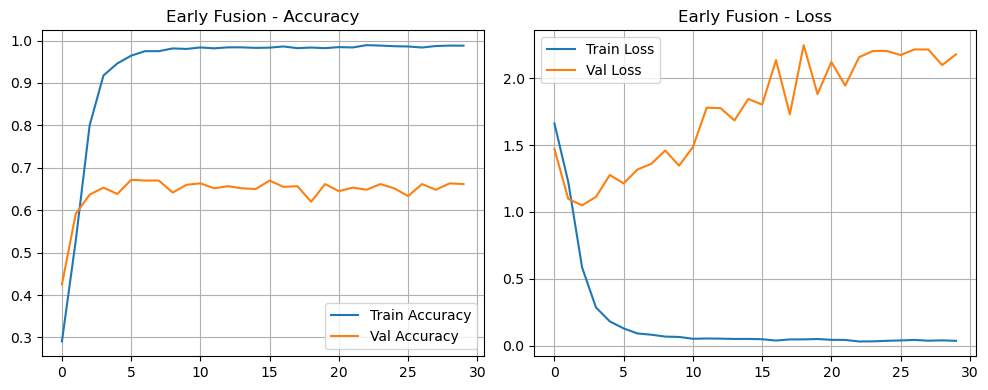

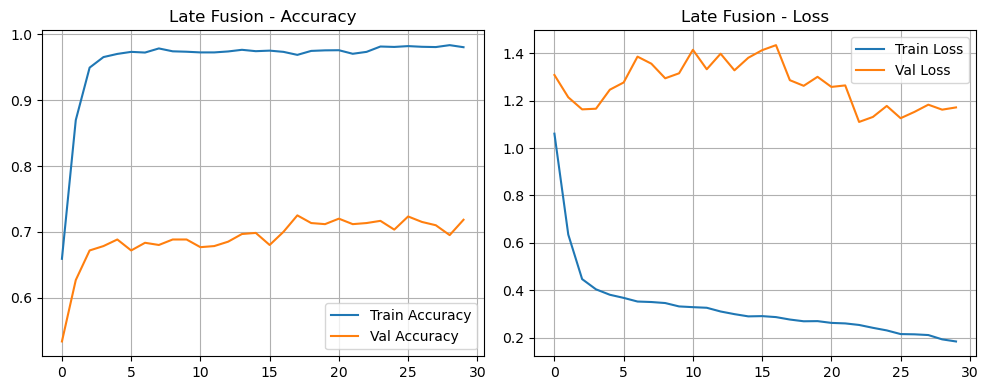

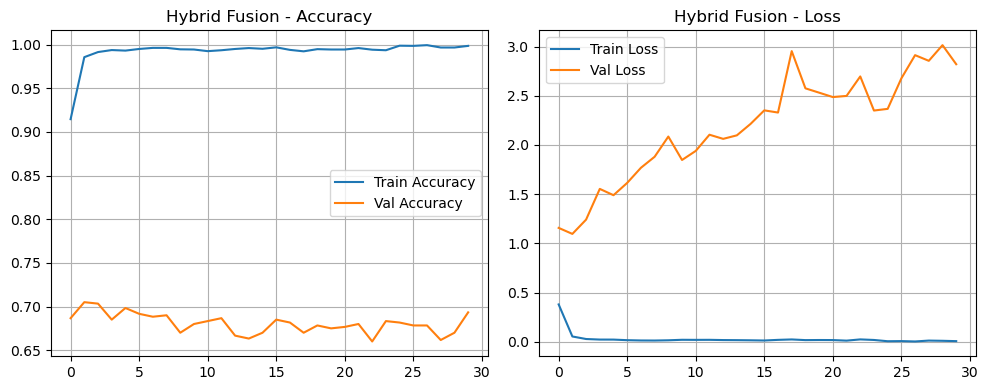

In [18]:
def plot_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_history(early_history, "Early Fusion")
plot_history(late_history, "Late Fusion")
plot_history(hybrid_history, "Hybrid Fusion")


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 463ms/step
Classification Report for Early Fusion:
              precision    recall  f1-score   support

       angry       0.58      0.57      0.57       100
     disgust       0.68      0.65      0.67       100
        fear       0.77      0.71      0.74       100
       happy       0.67      0.53      0.59       100
         sad       0.46      0.54      0.50       100
    surprise       0.63      0.74      0.68       100

    accuracy                           0.62       600
   macro avg       0.63      0.62      0.62       600
weighted avg       0.63      0.62      0.62       600



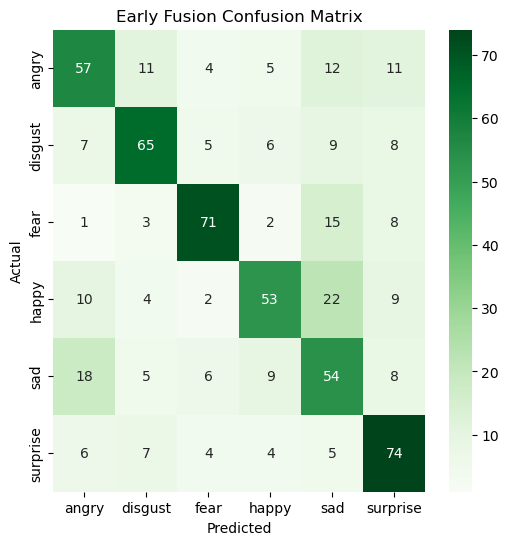

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step
Classification Report for Late Fusion:
              precision    recall  f1-score   support

       angry       0.63      0.67      0.65       100
     disgust       0.67      0.68      0.68       100
        fear       0.74      0.78      0.76       100
       happy       0.64      0.63      0.63       100
         sad       0.63      0.55      0.59       100
    surprise       0.69      0.70      0.70       100

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600



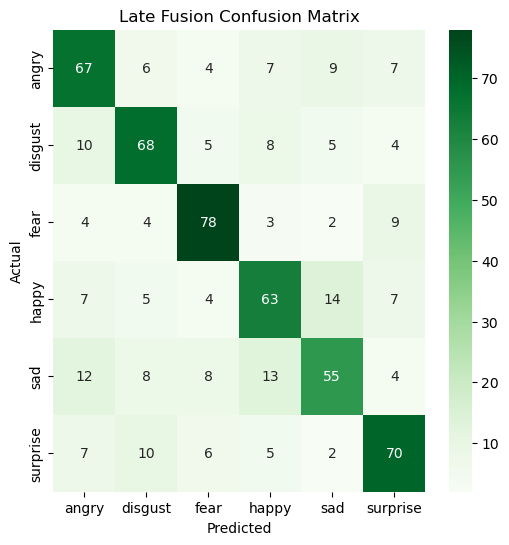

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step
Classification Report for Hybrid Fusion:
              precision    recall  f1-score   support

       angry       0.65      0.62      0.64       100
     disgust       0.63      0.70      0.66       100
        fear       0.76      0.79      0.77       100
       happy       0.61      0.59      0.60       100
         sad       0.61      0.57      0.59       100
    surprise       0.69      0.70      0.70       100

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600



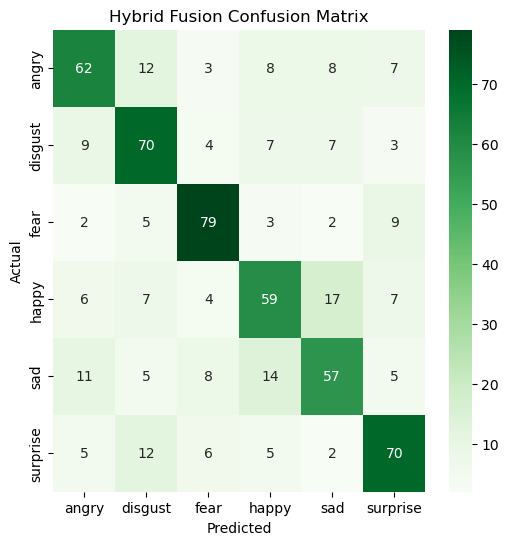

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, X_test_text, X_test_voice, y_test_text, model_name):
    # Predict probabilities
    y_pred_probs = model.predict([X_test_text, X_test_voice])
    
    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_text, axis=1)
    
    # Classification report
    print(f"Classification Report for {model_name} Fusion:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, label_encoder.classes_, title=f'{model_name} Fusion Confusion Matrix')

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(early_model, X_test_text, X_test_voice, y_test_text, "Early")
evaluate_model(late_model, X_test_text, X_test_voice, y_test_text, "Late")
evaluate_model(hybrid_model, X_test_text, X_test_voice, y_test_text, "Hybrid")
    
    